<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Graph-of-the-protocol" data-toc-modified-id="Graph-of-the-protocol-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Graph of the protocol</a></span></li><li><span><a href="#Weight-evolution-graph" data-toc-modified-id="Weight-evolution-graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Weight evolution graph</a></span></li><li><span><a href="#Evolution-of-weights" data-toc-modified-id="Evolution-of-weights-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evolution of weights</a></span></li></ul></div>

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns



from network import Protocol, Network, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

# Preamble

## General parameters

In [2]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 10.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

# Graph of the protocol

In [3]:
sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.010

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.00
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o', 'w']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

0.9969935711934551

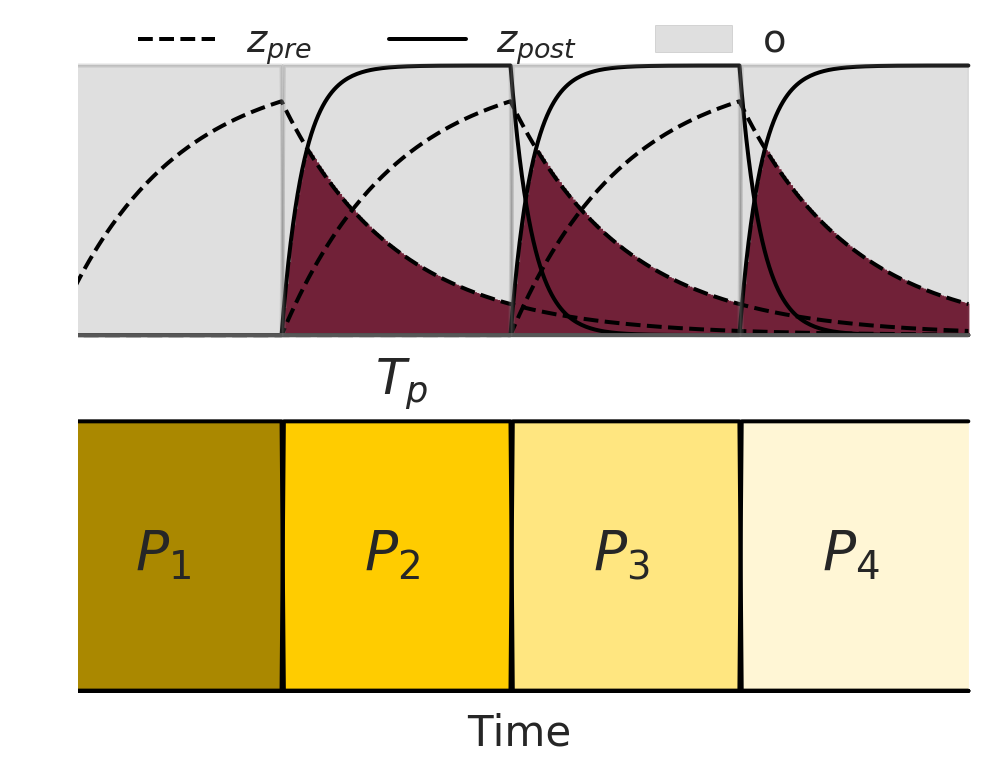

In [4]:
colors_ink = ['', '#aa8800ff', '#ffcc00ff', '#ffe680ff', '#fff6d5ff']
letters = [r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$']

save = True

o_set = timed_input.O.T
z_set = timed_input.z_pre.T
z_set_post = timed_input.z_post.T

cmap = matplotlib.cm.RdBu_r
color_red = cmap([0.01, 0.99])[1]
color_blue = cmap([0.01, 0.99])[0]


linewidth = 4
time = np.arange(0, manager.T_training_total, dt)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


# Plot the traces
for index in range(1, n_patterns - 1):
    if index == 1:
        pre_label = r'$z_{pre}$'
        post_label = r'$z_{post}$'
        fill_label = None # r'$w_{next}$'
    else:
        pre_label = None
        post_label = None
        fill_label = None
    z_pre = z_set[:, index]
    z_post = z_set_post[:, index + 1]
    ax1.plot(time, z_pre, linewidth=linewidth, ls='--', color='black', label=pre_label)
    ax1.plot(time, z_post, linewidth=linewidth, ls='-', color='black', label=post_label)

    # Fill the gap
    color = colors_ink[index]
    color = color_red
    where = (z_post > 0.010)
    aux = np.min(np.vstack((z_pre,z_post)), axis=0)
    ax1.fill_between(time, aux, where=where, interpolate=True, step='post', color=color)

# Plot the protocol
color_o = 'gray'
alpha_o = 0.25
# ax1.plot(time, o_set[:, 0], linewidth=linewidth, ls='--', color=color_o, alpha=alpha_o, label='o')
ax1.fill_between(time, 0.0 * o_set[:, 0], 0, color=color_o, alpha=alpha_o, label='o')

for index, o in enumerate(o_set.T):
    ax2.plot(time, o, linewidth=linewidth, ls='-', color='black')
    ax2.fill_between(time, o, 0, color=colors_ink[index])
    
    ax1.plot(time, o, linewidth=linewidth, ls='-', color=color_o, alpha=alpha_o)
    ax1.fill_between(time, o, 0, color=color_o, alpha=alpha_o)

# Set the x-limes
x_start = training_times_base + tau_s
x_end = (training_times_base + ipi_base) * n_patterns 
ax1.set_xlim([x_start, x_end])
ax2.set_xlim([x_start, x_end])

# Letters
start = training_times_base + ipi_base + 0.035
jump = training_times_base + ipi_base
for index, letter in enumerate(letters):
    ax2.text(start + index * jump, 0.45, letter, size=55)

ax2.text(0.280, -0.2, 'Time')
ax1.legend(frameon=False, loc=(0.05, 0.9), ncol=3)

# ax2.text(0.300, 0.9, r'$\{$', rotation = 270, fontsize=150)
ax2.text(0.240, 1.1, r'$T_{p}$', fontsize=50)
# ax2.text(0.550, 1.2, r'$\IPI$', fontsize=50)


if True:
    ax1.axis('off')
    ax2.axis('off')
    
# fig.tight_layout()

if save:
    directory = '../plot_producers/'
    file_name = 'protocol_all' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

# Weight evolution graph

../network.py:347: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pattern == epoch_end_string:
../connectivity_functions.py:15: RuntimeWarning: invalid value encountered in true_divide
  x = P / outer


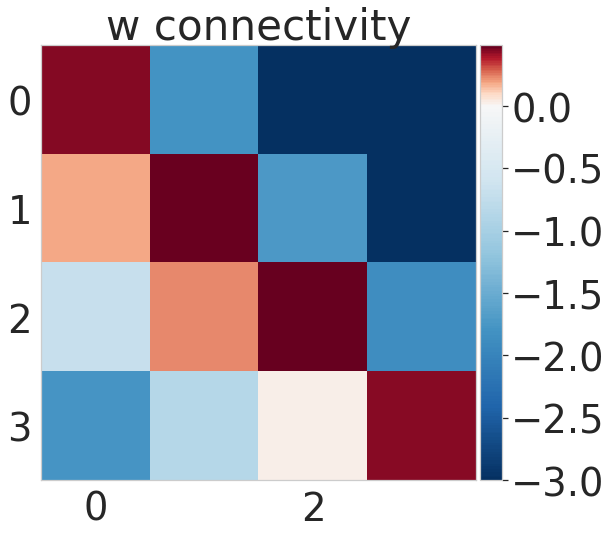

In [5]:
sigma_out = 0.00
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 4
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.00
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.100
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['s', 'o', 'w', 'z_pre', 'z_post', 'beta', 'p_post', 'p_pre', 'P']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol(protocol=protocol, plasticity_on=True)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

plot_weight_matrix(manager, vmin=vmin)

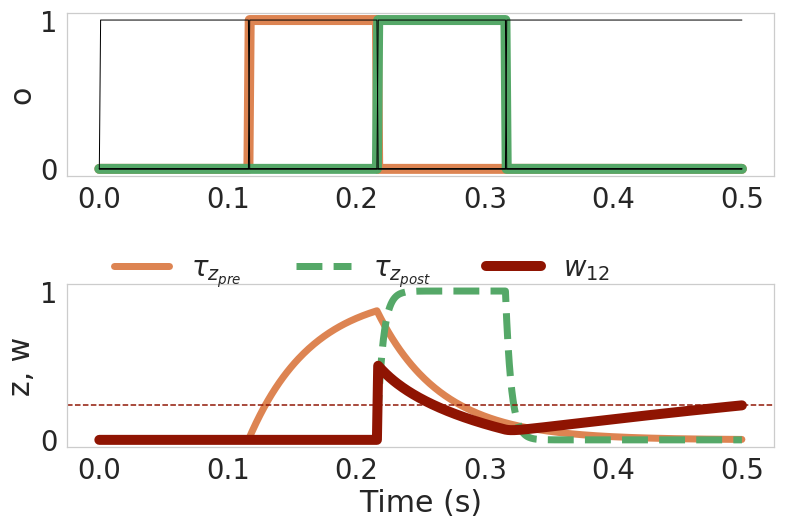

In [31]:
w = manager.history['w']
o = manager.history['o']
z_pre = manager.history['z_pre']
z_post = manager.history['z_post']


index1 = 1
index2 = 2
w21 = w[:, index2, index1]
w21_t = manager.nn.w[index2, index1]

fig = plt.figure()
with sns.axes_style("whitegrid", {'axes.grid': False}):

    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    lw_minus = 3

    ax2.plot(manager.time, z_pre[:, index1], '-', color=colors[index1], lw=lw - lw_minus, label=r'$\tau_{z_{pre}}$')
    ax2.plot(manager.time, z_post[:, index2], '--', color=colors[index2], lw=lw - lw_minus, label=r'$\tau_{z_{post}}$')
    label_weight = r'$w_{12}$'
    ax2.plot(manager.time, w21, label=label_weight, lw=lw, color='#8f1402')
    ax2.axhline(w21_t, ls='--', color='#8f1402')
    ax2.legend(frameon=False, ncol=3, loc=(0.05, 0.9))

    ax2.set_ylabel('z, w')

    if True:
        for i in range(n_patterns):
            if i in {index1, index2}:
                color = colors[i]
                lw1 = lw
                ax1.plot(manager.time, o[:, i], color=color, lw=lw1)


    for i in range(n_patterns):
        ax1.plot(manager.time, o[:, i], color='black', lw=lw - 9)

    ax1.set_ylabel('o')
    ax2.set_xlabel('Time (s)')

    fig.tight_layout()
    
directory = '../plot_producers/'
file_name = 'training'
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')


# Evolution of weights

In [29]:
from matplotlib import ticker


def plot_matrix(w, one_hypercolum=True, ax=None, vmin=None, vmax=None, title=True, transpose=False, colorbar=True):
    with sns.axes_style("whitegrid", {'axes.grid': False}):

        w = w

        # aux_max = np.max(np.abs(w))
        norm = MidpointNormalize(midpoint=0)
        cmap = matplotlib.cm.RdBu_r

        if ax is None:
            # sns.set_style("whitegrid", {'axes.grid': False})
            fig = plt.figure()
            ax = fig.add_subplot(111)
        if transpose:
            matrix_to_plot = w.T
        else:
            matrix_to_plot = w
        im = ax.imshow(matrix_to_plot, cmap=cmap, interpolation='None', norm=norm, vmin=vmin, vmax=vmax)

        if title:
            ax.set_title('w connectivity')

        if colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cb = ax.get_figure().colorbar(im, ax=ax, cax=cax)
            tick_locator = ticker.MaxNLocator(nbins=5)
            cb.locator = tick_locator
            cb.update_ticks()
            
    return ax

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

0.01
0.12
0.22
0.4


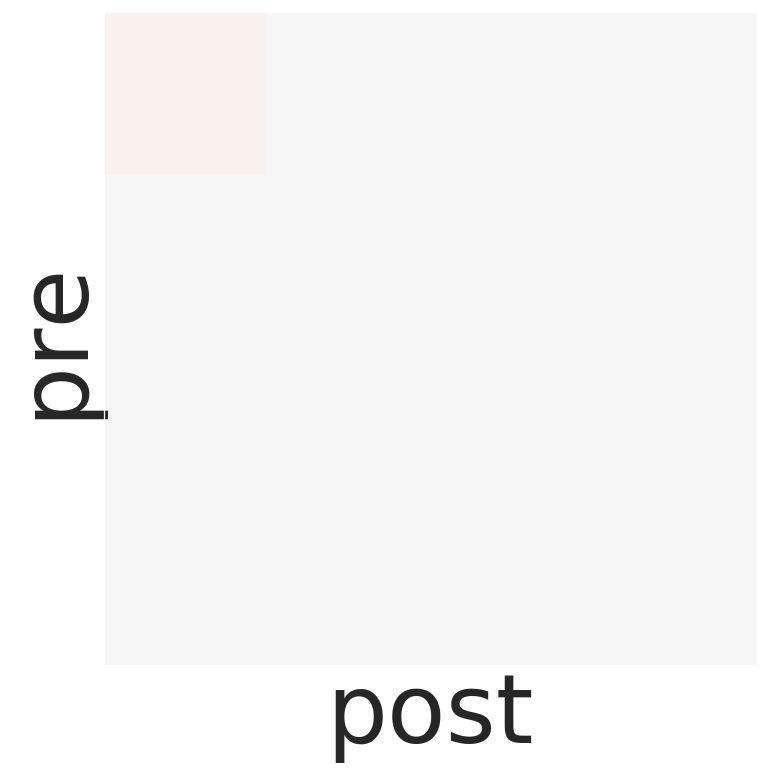

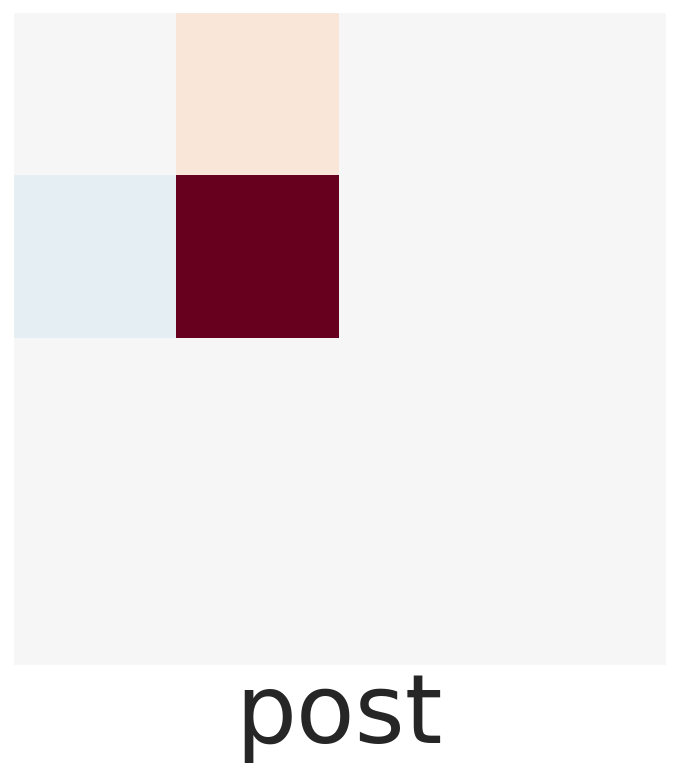

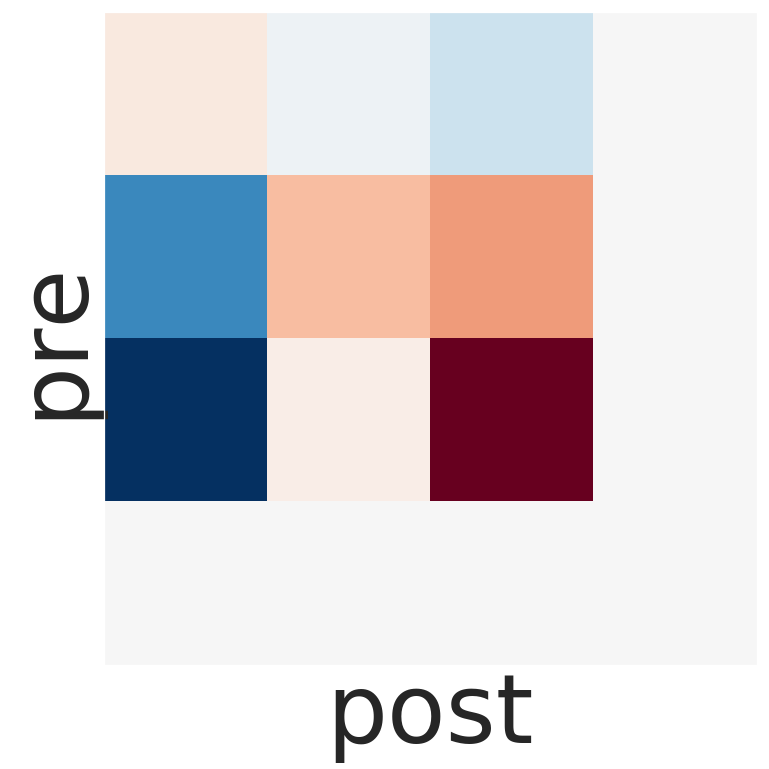

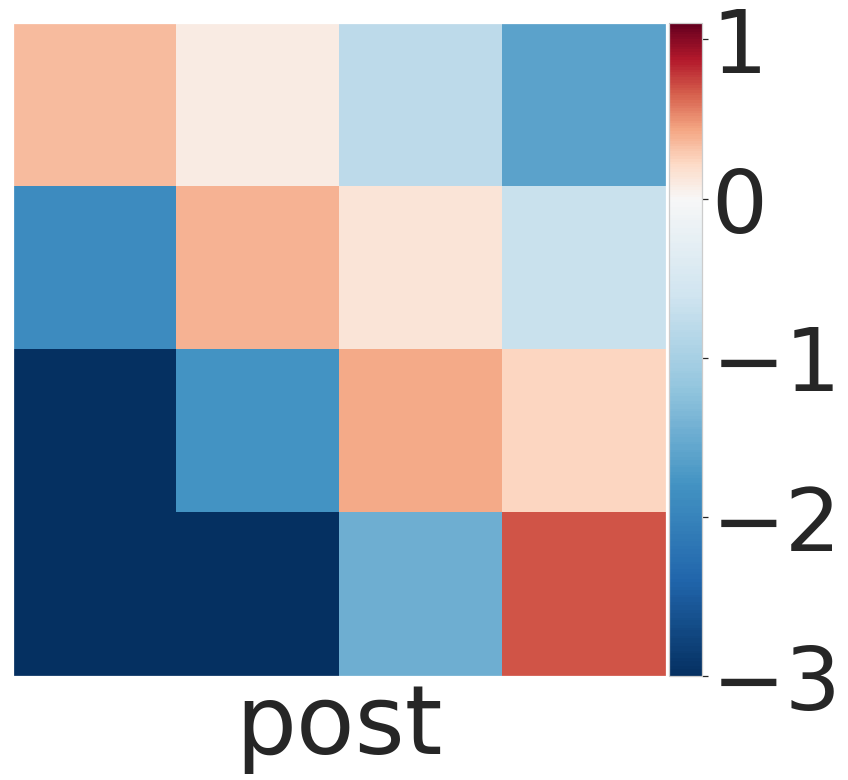

In [36]:
gs = gridspec.GridSpec(1, 4)
sns.set(font_scale=2.5)
vmin = -3.0
vmax = 1.1
times = []
sns.set(font_scale=8.0)


# Evolution of the matrix
plot_times = [0.010, 0.120, 0.220, 0.40 ]
for i, time in enumerate(plot_times):
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)

    t = time
    print(t)
    n_to_plot = int(t/ dt)
    w_to_plot = w[n_to_plot, :, :]
    if i < 3:
        colorbar = False
    else:
        colorbar = True
    ax = plot_matrix(w_to_plot, ax=ax, title=False, colorbar=colorbar, transpose=True, vmin=vmin, vmax=vmax)
    ax.set_xlabel('post')
    if i == 0:
        ax.set_ylabel('pre')
    if i == 2:
        ax.set_ylabel('pre')
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])

    directory = '../plot_producers/'
    file_name = 'matrix_evo' + str(t)
    format_string = '.png'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')
